# Week 5 Discussion Questions: Predict time series using recurrent neural networks

Import packages + helper functions

In [177]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

from tensorflow.keras.utils import timeseries_dataset_from_array

from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model

from tensorflow.keras.layers import Input, Flatten, Dense, SimpleRNN, LSTM, GRU
from tensorflow.keras.regularizers import l1

In [178]:
def plot_train_history(history, title):
    loss = hist.history['loss']
    val_loss = hist.history['val_loss']

    epochs = range(len(loss))

    plt.figure()

    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.xlabel('epoch')
    plt.ylabel('MSE Loss')
    plt.title(title)
    plt.legend()

    plt.show()

In [179]:
#function used to add diagonal lines to plots
def add_diagonal_line():
    xl = plt.xlim()
    yl = plt.ylim()
    shortestSide = min(xl[1], yl[1])
    plt.plot([min(y_predflat), shortestSide], [min(y_predflat), shortestSide], color="black", linestyle="--")

In [180]:
def plotallpred(Data, model, y, x):
    y = y_val.flatten()
    x = valPredict.flatten()
    plt.scatter(y_predflat, y_valflat)
    plt.xlabel("Predictions")
    plt.ylabel("True values")
    plt.title(f"{model} Model Predictions on {Data} Data")
    add_diagonal_line() 

## 1. Data Preparation

Import the data

In [181]:
stocks = pd.read_csv("daily-close-stock-prices.csv")
stocks

,Date,005930.KS,0700.HK,1810.HK,2010.SE,2222.SE,2330.TW,300750.SZ,600036.SS,600519.SS,...,TSLA.O,TWTR.K,UNH.N,UNP.N,UPS.N,V,WBC.AX,WFC,WMT,XOM
0,3/1/2000,5320,NaN,NaN,14.633313,NaN,62.629195,NaN,NaN,NaN,...,NaN,NaN,6.718750,10.765625,67.0625,NaN,10.387652,19.56250,66.8125,39.15625
1,4/1/2000,6110,NaN,NaN,14.633313,NaN,66.754472,NaN,NaN,NaN,...,NaN,NaN,6.632812,10.750000,64.9375,NaN,10.192890,18.59375,64.3125,38.40625
2,5/1/2000,5580,NaN,NaN,14.633313,NaN,68.254572,NaN,NaN,NaN,...,NaN,NaN,6.617188,10.750000,66.2500,NaN,10.005048,18.40625,63.0000,40.50000
3,6/1/2000,5620,NaN,NaN,14.633313,NaN,66.754472,NaN,NaN,NaN,...,NaN,NaN,6.898438,11.406250,68.0000,NaN,9.985275,19.21875,63.6875,42.59375
4,7/1/2000,5540,NaN,NaN,14.633313,NaN,64.879346,NaN,NaN,NaN,...,NaN,NaN,7.664062,11.328125,66.3750,NaN,9.985275,19.56250,68.5000,42.46875
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7839,28/10/2021,70700,488.2,21.85,129.000000,37.75,595.000000,607.20,54.22,1825.49,...,1077.04,54.29,455.440000,242.300000,213.9000,209.84,26.230000,51.36000,148.4500,64.31000
7840,29/10/2021,69800,481.0,21.35,129.000000,37.75,590.000000,639.22,53.97,1826.08,...,1114.00,53.54,460.470000,241.400000,213.4700,211.77,25.670000,51.16000,149.4200,64.47000
7841,30/10/2021,69800,481.0,21.35,129.000000,37.75,590.000000,639.22,53.97,1826.08,...,1114.00,53.54,460.470000,241.400000,213.4700,211.77,25.670000,51.16000,149.4200,64.47000
7842,31/10/2021,69800,481.0,21.35,126.800000,37.90,590.000000,639.22,53.97,1826.08,...,1114.00,53.54,460.470000,241.400000,213.4700,211.77,25.670000,51.16000,149.4200,64.47000


Set up date time index

In [182]:
stocks["Date"] = pd.to_datetime(stocks["Date"], dayfirst=True)
stocks = stocks.set_index("Date")


Convert from daily data to monthly average

In [183]:
stocks = stocks.resample('M').mean()

Select the stocks to be investigated

In [184]:
stocknames = ["ANZ.AX", "BOQ.AX", "CBA.AX", "NAB.AX"]
                
stocks = stocks[stocknames]



Transform data to percent change

In [185]:
changes = stocks.pct_change().dropna()
changes

,ANZ.AX,BOQ.AX,CBA.AX,NAB.AX
Date,,,,
2000-02-29,-0.033846,0.020081,0.014508,-0.047429
2000-03-31,0.025484,0.013432,-0.092761,0.002882
2000-04-30,0.083316,0.006231,0.059974,0.099349
2000-05-31,0.026375,-0.021900,0.082600,0.052036
2000-06-30,0.052917,0.012423,-0.004309,0.069498
...,...,...,...,...
2021-07-31,-0.027336,-0.003946,-0.023255,-0.023300
2021-08-31,0.025986,0.044456,0.030694,0.046007
2021-09-30,-0.029904,0.001256,-0.001057,0.028595


## 2. Data Exploration

In [186]:
changes *= 100
changes.mean()

ANZ.AX    0.530010
BOQ.AX    0.453169
CBA.AX    0.668656
NAB.AX    0.267869
dtype: float64

<AxesSubplot:xlabel='Date'>

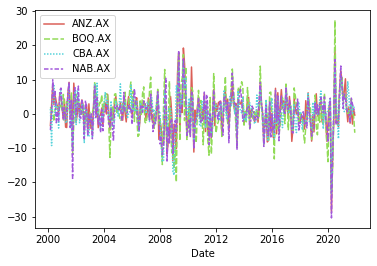

In [187]:
sns.lineplot(data = changes, palette = "hls")

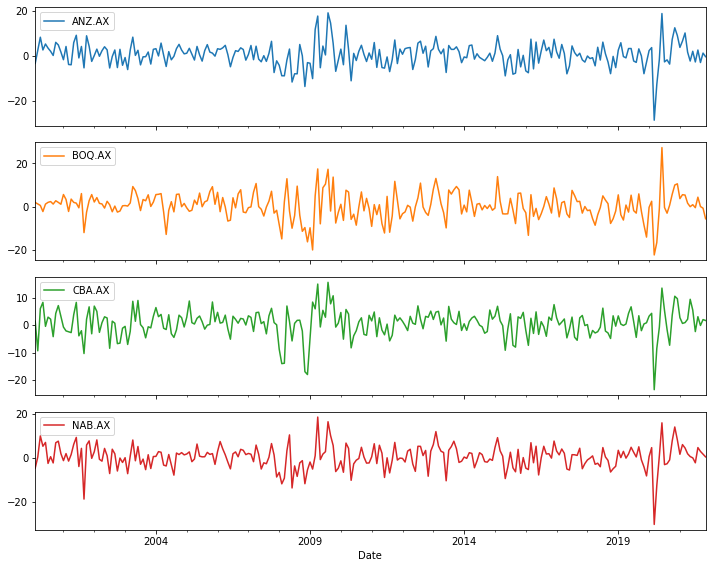

In [188]:
changes.plot(subplots = True, figsize = (10, 8))
plt.tight_layout()

In [189]:
changes.corr()

,ANZ.AX,BOQ.AX,CBA.AX,NAB.AX
ANZ.AX,1.000000,0.681271,0.712703,0.858728
BOQ.AX,0.681271,1.000000,0.592409,0.681119
CBA.AX,0.712703,0.592409,1.000000,0.734324
NAB.AX,0.858728,0.681119,0.734324,1.000000


## 3. Create dataset objects

In [190]:
# Num. of input time series.
numTS = changes.shape[1]

# How many prev. months to use.
seqLength = 6

# Predict the next month ahead.
ahead = 1

# The index of the first target.
delay = (seqLength+ahead-1)

In [191]:
# indices to split the data into train, val and test
numTrain = int(0.6 * len(changes))
numVal = int(0.2 * len(changes))
numTest = len(changes) - numTrain - numVal
print(f"# Train: {numTrain}, # Val: {numVal}, # Test: {numTest}")

trainDS = \
  timeseries_dataset_from_array(
    changes[:-delay],
    targets=changes[delay:],
    sequence_length=seqLength,
    end_index=numTrain)

valDS = \
  timeseries_dataset_from_array(
    changes[:-delay],
    targets=changes[delay:],
    sequence_length=seqLength,
    start_index=numTrain,
    end_index=numTrain+numVal)

testDS = \
  timeseries_dataset_from_array(
    changes[:-delay],
    targets=changes[delay:],
    sequence_length=seqLength,
    start_index=numTrain+numVal)


# Train: 157, # Val: 52, # Test: 53


In [192]:
X_train = np.concatenate(list(trainDS.map(lambda x, y: x)))
X_train.shape

(152, 6, 4)

In [193]:
y_train = np.concatenate(list(trainDS.map(lambda x, y: y)))
y_val = np.concatenate(list(valDS.map(lambda x, y: y)))
y_test = np.concatenate(list(testDS.map(lambda x, y: y)))

In [194]:
y_val.shape

(47, 4)

## Dense Network

Compile and fit model

In [195]:
tf.random.set_seed(1)
modelDense = Sequential([
    Input(shape=(seqLength, numTS)),
    Flatten(),
    Dense(50, activation="leaky_relu"),
    Dense(20, activation="leaky_relu"),
    Dense(numTS, activation="linear")
])

modelDense.compile(loss="mse", optimizer="adam")

es = EarlyStopping(patience=50, restore_best_weights=True, verbose=1)
hist = modelDense.fit(trainDS, epochs=1_000, \
  validation_data=valDS, callbacks=[es], verbose=0);

Restoring model weights from the end of the best epoch: 12.
Epoch 62: early stopping


Model Structure

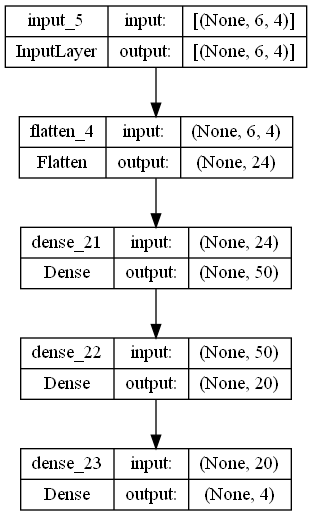

In [196]:
plot_model(modelDense, show_shapes=True)

Plot loss function

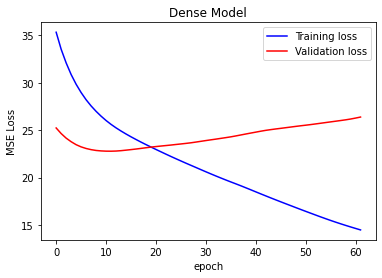

In [197]:
plot_train_history(hist, "Dense Model")

Model Assessment

In [198]:
mseTrain = {"Dense": modelDense.evaluate(trainDS, verbose=0)}
mseVal = {"Dense": modelDense.evaluate(valDS, verbose=0)}

Plot predictions

In [199]:
trainPredict = modelDense.predict(trainDS)
valPredict = modelDense.predict(valDS)

1/1 [==============================] - 0s 30ms/step


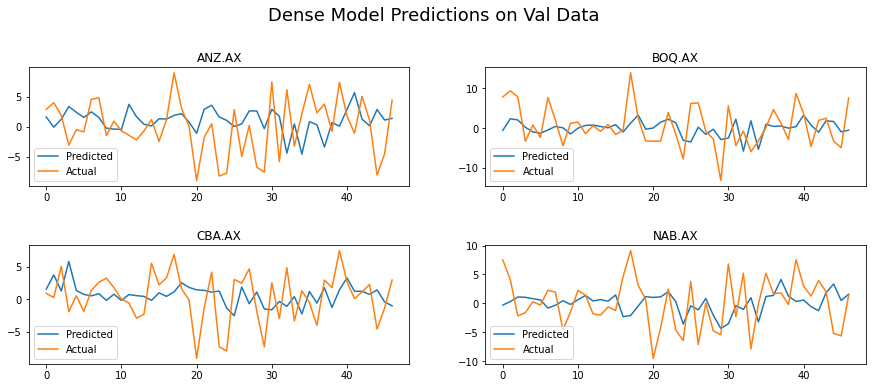

In [200]:
plt.figure(figsize = (15,12))
plt.subplots_adjust(hspace=0.5)
plt.suptitle("Dense Model Predictions on Val Data", fontsize=18, y=0.95)

for n, stock in enumerate(stocknames):
    ax = plt.subplot(4, 2, n+1)
    plt.plot(valPredict[:,n], label="Predicted")
    plt.plot(y_val[:,n], label="Actual")
    plt.title(f"{stocknames[n]}")
    plt.legend()



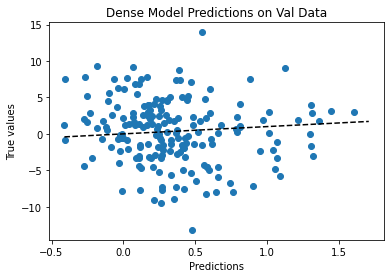

In [201]:
plotallpred("Val","Dense", y_val, valPredict)

## Simple RNN

Compile and fit the model

In [202]:
tf.random.set_seed(1)

modelSimple = Sequential([
    SimpleRNN(50, input_shape=(seqLength, numTS)),
    Dense(numTS, activation="linear")
])

modelSimple.compile(loss="mse", optimizer="adam")

es = EarlyStopping(patience=50, restore_best_weights=True, verbose=1)
hist = modelSimple.fit(trainDS, epochs=1_000, \
  validation_data=valDS, callbacks=[es], verbose=0);

Restoring model weights from the end of the best epoch: 9.
Epoch 59: early stopping


Model Structure

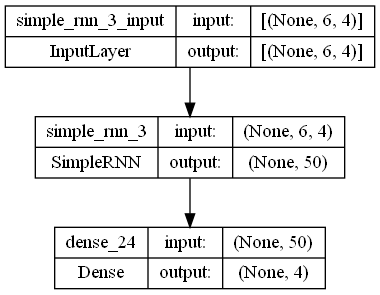

In [203]:
plot_model(modelSimple, show_shapes=True)

Plot loss function

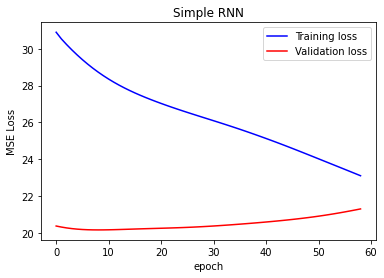

In [204]:
plot_train_history(hist, "Simple RNN")

Model Assessment

In [205]:
mseTrain["Simple"] = modelSimple.evaluate(trainDS, verbose=0)
mseVal["Simple"] = modelSimple.evaluate(valDS, verbose=0)

Plot Predictions

In [206]:
trainPredict = modelSimple.predict(trainDS)
valPredict = modelSimple.predict(valDS)

1/1 [==============================] - 0s 31ms/step


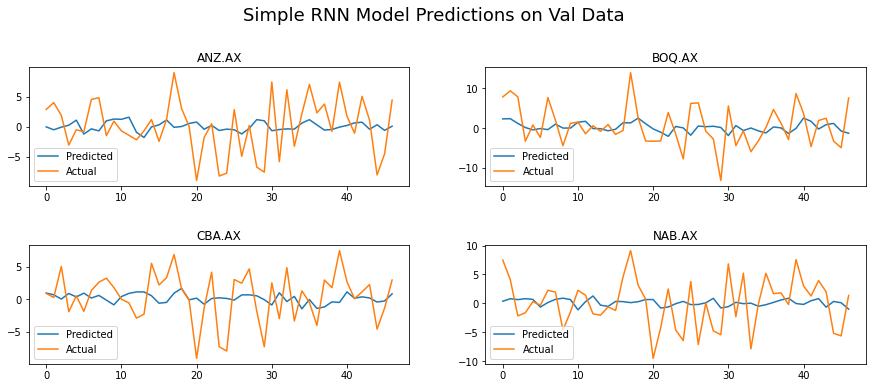

In [207]:
plt.figure(figsize = (15,12))
plt.subplots_adjust(hspace=0.5)
plt.suptitle("Simple RNN Model Predictions on Val Data", fontsize=18, y=0.95)

for n, stock in enumerate(stocknames):
    ax = plt.subplot(4, 2, n+1)
    plt.plot(valPredict[:,n], label="Predicted")
    plt.plot(y_val[:,n], label="Actual")
    plt.title(f"{stocknames[n]}")
    plt.legend()


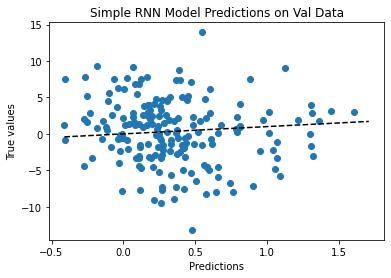

In [208]:
plotallpred("Val","Simple RNN", y_val, valPredict)

## LSTM

Compile and fit the model

In [209]:
tf.random.set_seed(1)

modelLSTM = Sequential([
    LSTM(50, input_shape=(seqLength, numTS)),
    Dense(numTS, activation="linear")
])

modelLSTM.compile(loss="mse", optimizer="adam")

es = EarlyStopping(patience=50, restore_best_weights=True, verbose=1)

hist = modelLSTM.fit(trainDS, epochs=1_000, \
  validation_data=valDS, callbacks=[es], verbose=0);

Restoring model weights from the end of the best epoch: 2.
Epoch 52: early stopping


Model Structure

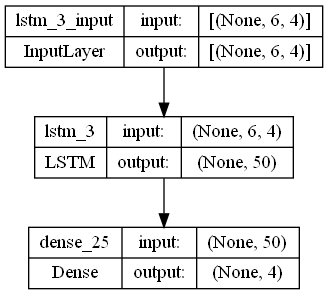

In [210]:
plot_model(modelLSTM, show_shapes=True)

Plot loss function

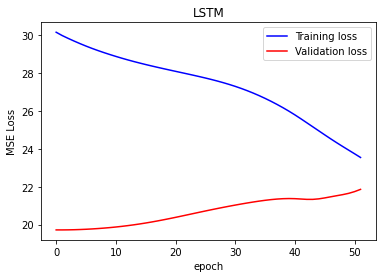

In [211]:
plot_train_history(hist, "LSTM")

Model Assessment

In [212]:
mseTrain["LSTM"] = modelLSTM.evaluate(trainDS, verbose=0)
mseVal["LSTM"] = modelLSTM.evaluate(valDS, verbose=0)

Plot predictions

In [213]:
trainPredict = modelLSTM.predict(trainDS)
valPredict = modelLSTM.predict(valDS)

1/1 [==============================] - 0s 28ms/step


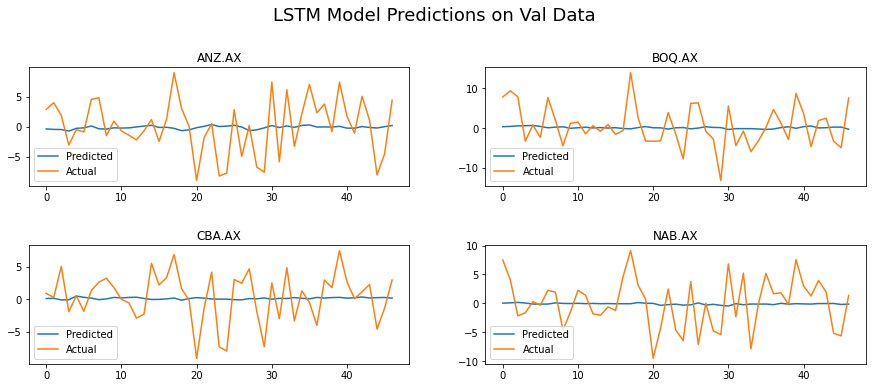

In [214]:
plt.figure(figsize = (15,12))
plt.subplots_adjust(hspace=0.5)
plt.suptitle("LSTM Model Predictions on Val Data", fontsize=18, y=0.95)

for n, stock in enumerate(stocknames):
    ax = plt.subplot(4, 2, n+1)
    plt.plot(valPredict[:,n], label="Predicted")
    plt.plot(y_val[:,n], label="Actual")
    plt.title(f"{stocknames[n]}")
    plt.legend()


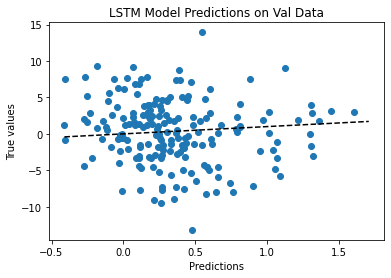

In [215]:
plotallpred("Val","LSTM", y_val, valPredict)

## GRU

Compile and fit model

In [216]:
tf.random.set_seed(1)

modelGRU = Sequential([
    GRU(50, input_shape=(seqLength, numTS)),
    Dense(numTS, activation="linear")
])

modelGRU.compile(loss="mse", optimizer="adam")

es = EarlyStopping(patience=50, restore_best_weights=True, verbose=1)

hist = modelGRU.fit(trainDS, epochs=1_000, \
  validation_data=valDS, callbacks=[es], verbose=0)

Restoring model weights from the end of the best epoch: 6.
Epoch 56: early stopping


Model Structure

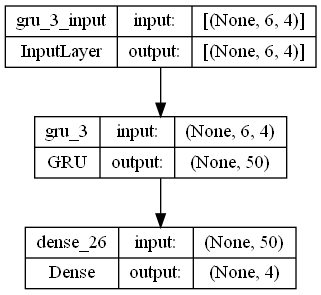

In [217]:
plot_model(modelGRU, show_shapes=True)

Plot loss function

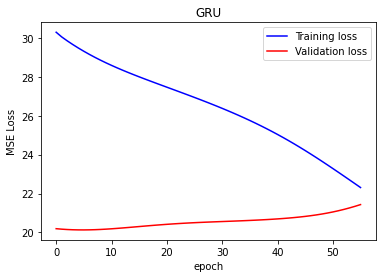

In [218]:
plot_train_history(hist, "GRU")

Model Assessment

In [219]:
mseTrain["GRU"] = modelGRU.evaluate(trainDS, verbose=0)
mseVal["GRU"] = modelGRU.evaluate(valDS, verbose=0)

Plot Predictions

In [220]:
trainPredict = modelGRU.predict(trainDS)
valPredict = modelGRU.predict(valDS)

1/1 [==============================] - 0s 28ms/step


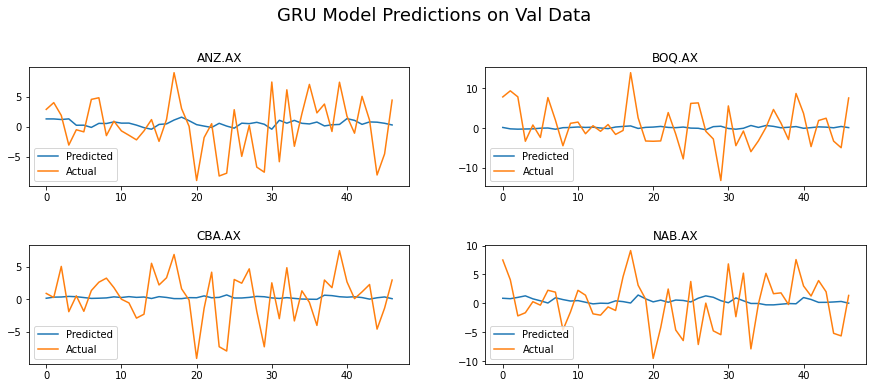

In [221]:
plt.figure(figsize = (15,12))
plt.subplots_adjust(hspace=0.5)
plt.suptitle("GRU Model Predictions on Val Data", fontsize=18, y=0.95)

for n, stock in enumerate(stocknames):
    ax = plt.subplot(4, 2, n+1)
    plt.plot(valPredict[:,n], label="Predicted")
    plt.plot(y_val[:,n], label="Actual")
    plt.title(f"{stocknames[n]}")
    plt.legend()


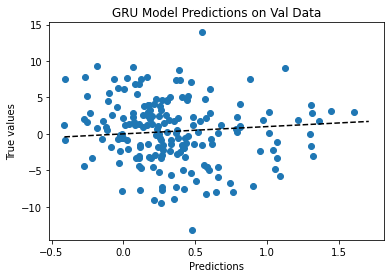

In [222]:
plotallpred("Val","GRU", y_val, valPredict)

## Final Model Selection

In [223]:
trainResults = pd.DataFrame({
    "Model": mseTrain.keys(), "MSE": mseTrain.values()
})
trainResults.sort_values("MSE", ascending=False)

,Model,MSE
2,LSTM,29.841364
3,GRU,29.173388
1,Simple,28.557543
0,Dense,25.275534


In [224]:
valResults = pd.DataFrame({
    "Model": mseVal.keys(), "MSE": mseVal.values()
})
valResults.sort_values("MSE", ascending=False)

,Model,MSE
0,Dense,22.780451
1,Simple,20.163755
3,GRU,20.129171
2,LSTM,19.720690


Since LSTM has the lowest validation MSE, we choose LSTM and this is fitted on test data set.

In [228]:
modelLSTM.evaluate(testDS, verbose=0)

49.41638946533203

In [229]:
testPredict = modelLSTM.predict(valDS)

1/1 [==============================] - 0s 31ms/step


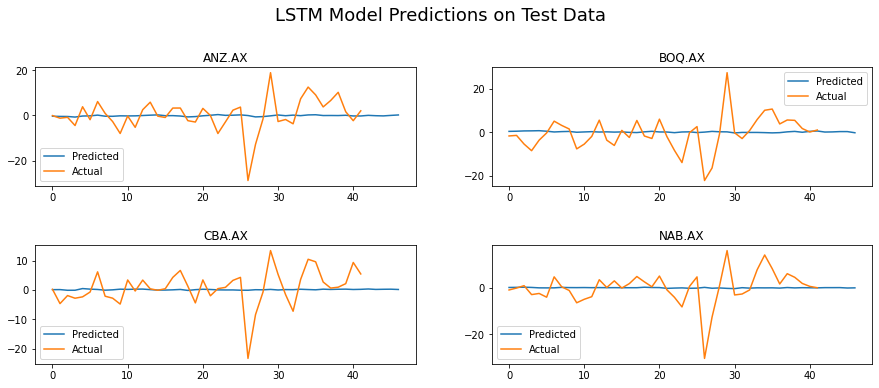

In [230]:
plt.figure(figsize = (15,12))
plt.subplots_adjust(hspace=0.5)
plt.suptitle("LSTM Model Predictions on Test Data", fontsize=18, y=0.95)

for n, stock in enumerate(stocknames):
    ax = plt.subplot(4, 2, n+1)
    plt.plot(testPredict[:,n], label="Predicted")
    plt.plot(y_test[:,n], label="Actual")
    plt.title(f"{stocknames[n]}")
    plt.legend()


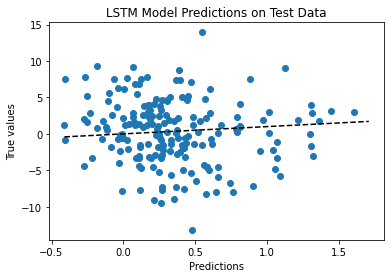

In [232]:
plotallpred("Test","LSTM", y_test, testPredict)